In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score
import lightgbm as lgbm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import random
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.base import clone
from lightgbm import LGBMClassifier
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## Ant Colony Optimize

In [13]:
class ImprovedACOFeatureSelection:
    """
    Improved Ant Colony Optimization for Feature Selection with LGBM
    """
    
    def __init__(self, n_features, n_ants=10, max_iter=20, alpha=1, beta=2, 
                 rho=0.5, min_features=5, max_features=None):
        self.n_features = n_features
        self.n_ants = n_ants
        self.max_iter = max_iter
        self.alpha = alpha  # pheromone importance
        self.beta = beta    # heuristic importance
        self.rho = rho      # pheromone evaporation rate
        self.min_features = min_features
        self.max_features = max_features or n_features // 2

        # Initialize pheromone matrix for feature selection
        self.pheromone = np.ones(n_features) * 0.1
        self.best_subset = None
        self.best_score = -np.inf  # Maximize accuracy score
        self.best_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}
        self.history = []
        self.feature_heuristics = None

    def _calculate_heuristics(self, X, y):
        """Calculate heuristic information for each feature"""
        from sklearn.feature_selection import mutual_info_classif
        from sklearn.preprocessing import LabelEncoder
        
        # Handle categorical target if needed
        if y.dtype == 'object':
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)
        else:
            y_encoded = y
            
        # Calculate mutual information
        mi_scores = mutual_info_classif(X, y_encoded, random_state=42)
        
        # Normalize to [0.1, 1] range
        mi_scores = mi_scores / (mi_scores.max() + 1e-10)
        mi_scores = mi_scores * 0.9 + 0.1  # Scale to [0.1, 1]
        
        return mi_scores

    def _evaluate_subset_detailed(self, X, y, feature_subset, cv_folds=3):
        """Evaluate feature subset with detailed metrics using cross-validation"""
        if len(feature_subset) == 0:
            return {'accuracy': -np.inf, 'precision': 0, 'recall': 0, 'f1': 0}
            
        X_subset = X.iloc[:, feature_subset] if hasattr(X, 'iloc') else X[:, feature_subset]
        
        # LGBM parameters
        lgb_params = {
            'objective': 'multiclass' if len(np.unique(y)) > 2 else 'binary',
            'num_class': len(np.unique(y)) if len(np.unique(y)) > 2 else None,
            'metric': 'multi_logloss' if len(np.unique(y)) > 2 else 'binary_logloss',
            'verbosity': -1,
            'random_state': 42,
            'n_estimators': 100,
            'learning_rate': 0.1
        }
        
        try:
            # Use stratified k-fold for better evaluation
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            model = lgb.LGBMClassifier(**lgb_params)
            
            # Calculate different metrics
            scoring_methods = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
            results = {}
            
            for scoring in scoring_methods:
                scores = cross_val_score(model, X_subset, y, cv=cv, scoring=scoring)
                metric_name = scoring.replace('_macro', '')
                results[metric_name] = scores.mean()
            
            return results
            
        except Exception as e:
            print(f"Error evaluating subset: {e}")
            return {'accuracy': -np.inf, 'precision': 0, 'recall': 0, 'f1': 0}

    def _construct_solution(self, ant_id):
        """Construct a solution (feature subset) for one ant"""
        selected_features = []
        available_features = list(range(self.n_features))
        
        # Randomly select number of features within bounds
        n_select = random.randint(self.min_features, 
                                min(self.max_features, self.n_features))
        
        for _ in range(n_select):
            if not available_features:
                break
                
            # Calculate selection probabilities
            probabilities = []
            for feature in available_features:
                pheromone = self.pheromone[feature]
                heuristic = self.feature_heuristics[feature]
                prob = (pheromone ** self.alpha) * (heuristic ** self.beta)
                probabilities.append(prob)
            
            # Normalize probabilities
            probabilities = np.array(probabilities)
            probabilities = probabilities / (probabilities.sum() + 1e-10)
            
            # Roulette wheel selection
            selected_idx = np.random.choice(len(available_features), p=probabilities)
            selected_feature = available_features[selected_idx]
            
            selected_features.append(selected_feature)
            available_features.remove(selected_feature)
        
        return selected_features

    def _update_pheromone(self, all_subsets, all_scores):
        """Update pheromone trails"""
        # Evaporation
        self.pheromone *= (1 - self.rho)
        
        # Find best solutions in this iteration
        sorted_indices = np.argsort(all_scores)[::-1]  # Descending order
        n_elite = max(1, len(all_scores) // 4)  # Top 25% solutions
        
        # Deposit pheromone for elite solutions
        for i in range(n_elite):
            idx = sorted_indices[i]
            subset = all_subsets[idx]
            score = all_scores[idx]
            
            # Amount of pheromone to deposit (normalized score)
            if score > 0:
                delta_pheromone = score * (n_elite - i) / n_elite  # Weight by rank
                
                for feature in subset:
                    self.pheromone[feature] += delta_pheromone

        # Ensure minimum pheromone level
        self.pheromone = np.clip(self.pheromone, 0.001, 10.0)

    def fit(self, X, y, validation_split=0.2):
        """
        Fit ACO feature selection
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        validation_split : float
            Fraction of data to use for validation
        """
        # Split data into train and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42, 
            stratify=y if len(np.unique(y)) > 1 else None
        )
        
        # Calculate heuristic information
        print("Calculating feature heuristics...")
        self.feature_heuristics = self._calculate_heuristics(X_train, y_train)
        
        print(f"Starting ACO optimization with {self.n_ants} ants for {self.max_iter} iterations...")
        
        for iteration in range(self.max_iter):
            all_subsets = []
            all_scores = []
            
            # Each ant constructs a solution
            for ant in range(self.n_ants):
                subset = self._construct_solution(ant)
                metrics = self._evaluate_subset_detailed(X_train, y_train, subset)
                score = metrics['accuracy']  # Primary optimization metric
                
                all_subsets.append(subset)
                all_scores.append(score)
                
                # Update global best
                if score > self.best_score:
                    self.best_score = score
                    self.best_subset = subset.copy()
                    self.best_metrics = metrics.copy()
            
            # Update pheromone
            self._update_pheromone(all_subsets, all_scores)
            
            # Validation metrics for best subset
            val_metrics = self._evaluate_subset_detailed(X_val, y_val, self.best_subset)
            
            # Record detailed history - KEEP ALL ORIGINAL TRACKING
            self.history.append({
                'iteration': iteration + 1,
                'train_accuracy': self.best_metrics['accuracy'],
                'train_precision': self.best_metrics['precision'],
                'train_recall': self.best_metrics['recall'],
                'train_f1': self.best_metrics['f1'],
                'val_accuracy': val_metrics['accuracy'],
                'val_precision': val_metrics['precision'],
                'val_recall': val_metrics['recall'],
                'val_f1': val_metrics['f1'],
                'n_features': len(self.best_subset),
                'avg_accuracy': np.mean(all_scores)
            })
            
            print(f"Iter {iteration+1:2d}/{self.max_iter}: "
                  f"Train Acc: {self.best_metrics['accuracy']:.4f}, "
                  f"Val Acc: {val_metrics['accuracy']:.4f}, "
                  f"Val F1: {val_metrics['f1']:.4f}, "
                  f"Features: {len(self.best_subset)}")

        return self.best_subset

    def plot_convergence(self):
        """Plot optimization convergence with reduced charts"""
        if not self.history:
            print("No history available for plotting")
            return
            
        # Set style for better looking plots
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(12, 8))
        
        iterations = [h['iteration'] for h in self.history]
        
        # Plot 1: Accuracy comparison (KEEP)
        plt.subplot(2, 2, 1)
        train_acc = [h['train_accuracy'] for h in self.history]
        val_acc = [h['val_accuracy'] for h in self.history]
        avg_acc = [h['avg_accuracy'] for h in self.history]
        
        plt.plot(iterations, train_acc, 'b-o', label='Best Train Accuracy', linewidth=2)
        plt.plot(iterations, val_acc, 'r-s', label='Validation Accuracy', linewidth=2)
        plt.plot(iterations, avg_acc, 'g--', label='Average Accuracy', alpha=0.7)
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Evolution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # REMOVED: Precision comparison
        # REMOVED: Recall comparison  
        # REMOVED: F1-Score comparison
        # REMOVED: Number of features
        # REMOVED: All metrics combined on validation set
        
        # Plot 2: Pheromone levels (from plot_detailed_analysis)
        plt.subplot(2, 2, 2)
        all_features = np.arange(len(self.pheromone))
        colors = ['red' if i in self.best_subset else 'lightblue' for i in all_features]
        bars = plt.bar(all_features, self.pheromone, color=colors)
        plt.xlabel('Feature Index')
        plt.ylabel('Pheromone Level')
        plt.title('Pheromone Distribution\n(Red = Selected Features)')
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Heuristic values (from plot_detailed_analysis)
        plt.subplot(2, 2, 3)
        colors = ['red' if i in self.best_subset else 'lightgreen' for i in all_features]
        bars = plt.bar(all_features, self.feature_heuristics, color=colors)
        plt.xlabel('Feature Index')
        plt.ylabel('Heuristic Value (MI Score)')
        plt.title('Feature Heuristics\n(Red = Selected Features)')
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Combined importance for selected features (from plot_detailed_analysis)
        plt.subplot(2, 2, 4)
        if self.best_subset:
            selected_importance = [(i, self.pheromone[i] * self.feature_heuristics[i]) 
                                 for i in self.best_subset]
            selected_importance.sort(key=lambda x: x[1], reverse=True)
            
            indices, importances = zip(*selected_importance)
            feature_labels = [f'F{i}' for i in indices]
            
            plt.barh(range(len(indices)), importances, color='orange')
            plt.yticks(range(len(indices)), feature_labels)
            plt.xlabel('Importance Score')
            plt.title('Selected Feature Importance')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def plot_detailed_analysis(self, feature_names=None):
        """Plot detailed analysis - KEEP original but remove unwanted charts"""
        if not self.history or not self.best_subset:
            print("No data available for detailed analysis")
            return
            
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(12, 8))
        
        # Plot 1: Metrics correlation heatmap (final iteration) - KEEP
        plt.subplot(2, 2, 1)
        final_metrics = self.history[-1]
        metrics_data = {
            'Train': [final_metrics['train_accuracy'], final_metrics['train_precision'], 
                     final_metrics['train_recall'], final_metrics['train_f1']],
            'Validation': [final_metrics['val_accuracy'], final_metrics['val_precision'],
                          final_metrics['val_recall'], final_metrics['val_f1']]
        }
        
        df_metrics = pd.DataFrame(metrics_data, 
                                 index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
        
        sns.heatmap(df_metrics, annot=True, cmap='RdYlBu_r', center=0.5, 
                   fmt='.3f', cbar_kws={'label': 'Score'})
        plt.title('Final Metrics Comparison')
        
        # REMOVED: Pheromone levels (moved to plot_convergence)
        # REMOVED: Heuristic values (moved to plot_convergence)
        # REMOVED: Combined importance (moved to plot_convergence)
        # REMOVED: Feature selection stability
        # REMOVED: Performance improvement over iterations
        
        # Plot 2: Feature importance with names if available
        plt.subplot(2, 2, 2)
        if self.best_subset:
            selected_importance = [(i, self.pheromone[i] * self.feature_heuristics[i]) 
                                 for i in self.best_subset]
            selected_importance.sort(key=lambda x: x[1], reverse=True)
            
            indices, importances = zip(*selected_importance)
            feature_labels = [feature_names[i] if feature_names and i < len(feature_names) else f'F{i}' for i in indices]
            
            # Show top 10 features if more than 10
            if len(indices) > 10:
                indices = indices[:10]
                importances = importances[:10]
                feature_labels = feature_labels[:10]
            
            plt.barh(range(len(indices)), importances, color='orange')
            plt.yticks(range(len(indices)), feature_labels)
            plt.xlabel('Importance Score')
            plt.title('Top Selected Feature Importance')
            plt.grid(True, alpha=0.3)
        
        # Plot 3: Training progress
        plt.subplot(2, 2, 3)
        iterations = [h['iteration'] for h in self.history]
        val_acc = [h['val_accuracy'] for h in self.history]
        train_acc = [h['train_accuracy'] for h in self.history]
        
        plt.plot(iterations, train_acc, 'b-o', label='Training Accuracy', linewidth=2)
        plt.plot(iterations, val_acc, 'r-s', label='Validation Accuracy', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Feature count over iterations
        plt.subplot(2, 2, 4)
        n_features = [h['n_features'] for h in self.history]
        plt.plot(iterations, n_features, 'purple', marker='o', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('Number of Features')
        plt.title('Feature Count Evolution')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def get_selected_features(self, feature_names=None):
        """Get selected features with their importance"""
        if not self.best_subset:
            return {}
            
        result = {}
        for i, feature_idx in enumerate(self.best_subset):
            importance = self.pheromone[feature_idx] * self.feature_heuristics[feature_idx]
            
            if feature_names and feature_idx < len(feature_names):
                result[feature_names[feature_idx]] = {
                    'index': feature_idx,
                    'importance': importance,
                    'pheromone': self.pheromone[feature_idx],
                    'heuristic': self.feature_heuristics[feature_idx]
                }
            else:
                result[f'feature_{feature_idx}'] = {
                    'index': feature_idx,
                    'importance': importance,
                    'pheromone': self.pheromone[feature_idx],
                    'heuristic': self.feature_heuristics[feature_idx]
                }
                
        return result


def run_lgbm_feature_selection(data_path, target_column='group', 
                              n_ants=15, max_iter=20):
    """
    Run ACO feature selection specifically for LGBM on full dataset
    """
    # Load data
    print(f"Loading data from {data_path}...")
    data = pd.read_csv(data_path)
    
    print(f"Full dataset shape: {data.shape}")
    print(f"Loading complete - using entire dataset with {len(data)} samples")
    
    # Prepare features and target
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    feature_names = X.columns.tolist()
    
    print(f"Number of features: {len(feature_names)}")
    print(f"Target classes: {y.unique()}")
    
    # Baseline evaluation with all features
    print("\n=== Baseline (All Features) ===")
    lgb_model = lgb.LGBMClassifier(random_state=42, verbosity=-1)
    
    # Calculate multiple metrics for baseline
    baseline_accuracy = cross_val_score(lgb_model, X, y, cv=5, scoring='accuracy').mean()
    baseline_precision = cross_val_score(lgb_model, X, y, cv=5, scoring='precision_macro').mean()
    baseline_recall = cross_val_score(lgb_model, X, y, cv=5, scoring='recall_macro').mean()
    baseline_f1 = cross_val_score(lgb_model, X, y, cv=5, scoring='f1_macro').mean()
    
    baseline_metrics = {
        'accuracy': baseline_accuracy,
        'precision': baseline_precision,
        'recall': baseline_recall,
        'f1': baseline_f1
    }
    
    print(f"Baseline Accuracy:  {baseline_accuracy:.4f}")
    print(f"Baseline Precision: {baseline_precision:.4f}")
    print(f"Baseline Recall:    {baseline_recall:.4f}")
    print(f"Baseline F1-Score:  {baseline_f1:.4f}")
    
    # ACO Feature Selection
    print("\n=== ACO Feature Selection ===")
    start_time = time.time()
    
    aco = ImprovedACOFeatureSelection(
        n_features=len(feature_names),
        n_ants=n_ants,
        max_iter=max_iter,
        alpha=1.0,
        beta=2.0,
        rho=0.1,
        min_features=5,
        max_features=min(30, len(feature_names)//2)
    )
    
    selected_indices = aco.fit(X, y)
    elapsed_time = time.time() - start_time
    
    print(f"\nOptimization completed in {elapsed_time:.2f} seconds")
    
    # Evaluate selected features with detailed metrics
    print("\n=== Selected Features Evaluation ===")
    X_selected = X.iloc[:, selected_indices]
    
    selected_accuracy = cross_val_score(lgb_model, X_selected, y, cv=5, scoring='accuracy').mean()
    selected_precision = cross_val_score(lgb_model, X_selected, y, cv=5, scoring='precision_macro').mean()
    selected_recall = cross_val_score(lgb_model, X_selected, y, cv=5, scoring='recall_macro').mean()
    selected_f1 = cross_val_score(lgb_model, X_selected, y, cv=5, scoring='f1_macro').mean()
    
    selected_metrics = {
        'accuracy': selected_accuracy,
        'precision': selected_precision,
        'recall': selected_recall,
        'f1': selected_f1
    }
    
    print(f"Selected Accuracy:  {selected_accuracy:.4f}")
    print(f"Selected Precision: {selected_precision:.4f}")
    print(f"Selected Recall:    {selected_recall:.4f}")
    print(f"Selected F1-Score:  {selected_f1:.4f}")
    print(f"Feature reduction: {len(feature_names)} -> {len(selected_indices)} "
          f"({100*(1-len(selected_indices)/len(feature_names)):.1f}% reduction)")
    
    # Show selected features
    selected_features = aco.get_selected_features(feature_names)
    print(f"\nSelected Features ({len(selected_features)}):")
    
    # Sort by importance
    sorted_features = sorted(selected_features.items(), 
                           key=lambda x: x[1]['importance'], reverse=True)
    
    for i, (name, info) in enumerate(sorted_features[:10]):  # Top 10
        print(f"{i+1:2d}. {name:20s} (importance: {info['importance']:.3f})")
    
    if len(sorted_features) > 10:
        print(f"    ... and {len(sorted_features)-10} more features")
    
    # Plot results with detailed analysis
    print("\n=== Generating Visualizations ===")
    aco.plot_convergence()
    aco.plot_detailed_analysis(feature_names)
    
    # Create comparison plot - KEEP ORIGINAL
    plt.figure(figsize=(12, 8))
    
    # Comparison bar plot
    plt.subplot(2, 2, 1)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    baseline_values = [baseline_metrics['accuracy'], baseline_metrics['precision'], 
                      baseline_metrics['recall'], baseline_metrics['f1']]
    selected_values = [selected_metrics['accuracy'], selected_metrics['precision'],
                      selected_metrics['recall'], selected_metrics['f1']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, baseline_values, width, label='All Features', color='lightblue')
    plt.bar(x + width/2, selected_values, width, label='Selected Features', color='orange')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Performance Comparison: All vs Selected Features')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Feature count comparison
    plt.subplot(2, 2, 2)
    categories = ['All Features', 'Selected Features']
    counts = [len(feature_names), len(selected_indices)]
    colors = ['lightcoral', 'lightgreen']
    
    bars = plt.bar(categories, counts, color=colors)
    plt.ylabel('Number of Features')
    plt.title('Feature Count Comparison')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    # Improvement/degradation plot
    plt.subplot(2, 2, 3)
    improvements = [selected_values[i] - baseline_values[i] for i in range(len(metrics))]
    colors = ['green' if x >= 0 else 'red' for x in improvements]
    
    bars = plt.bar(metrics, improvements, color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.ylabel('Performance Change')
    plt.title('Performance Change (Selected - All)')
    plt.xticks(rotation=45)
    
    # Add value labels
    for bar, imp in zip(bars, improvements):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.001 if imp >= 0 else -0.001),
                f'{imp:+.3f}', ha='center', va='bottom' if imp >= 0 else 'top')
    
    plt.grid(True, alpha=0.3)
    
    # Feature reduction visualization
    plt.subplot(2, 2, 4)
    reduction_pct = 100 * (1 - len(selected_indices) / len(feature_names))
    remaining_pct = 100 - reduction_pct
    
    sizes = [remaining_pct, reduction_pct]
    labels = [f'Selected\n({len(selected_indices)} features)', 
              f'Removed\n({len(feature_names) - len(selected_indices)} features)']
    colors = ['lightgreen', 'lightcoral']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Feature Selection Results')
    
    plt.tight_layout()
    plt.show()
    
    # Summary with detailed metrics comparison - KEEP ORIGINAL
    print("\n" + "="*80)
    print("DETAILED PERFORMANCE SUMMARY")
    print("="*80)
    
    print(f"{'Metric':<15} {'All Features':<15} {'Selected':<15} {'Change':<15} {'% Change':<15}")
    print("-" * 75)
    
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        baseline_val = baseline_metrics[metric]
        selected_val = selected_metrics[metric]
        change = selected_val - baseline_val
        pct_change = (change / baseline_val) * 100
        
        print(f"{metric.capitalize():<15} {baseline_val:<15.4f} {selected_val:<15.4f} "
              f"{change:<+15.4f} {pct_change:<+15.2f}%")
    
    print("-" * 75)
    print(f"{'Features':<15} {len(feature_names):<15d} {len(selected_indices):<15d} "
          f"{len(selected_indices) - len(feature_names):<+15d} "
          f"{100*(len(selected_indices)/len(feature_names) - 1):<+15.1f}%")
    
    # Overall assessment - KEEP ORIGINAL
    print("\nOVERALL ASSESSMENT:")
    accuracy_improvement = selected_metrics['accuracy'] - baseline_metrics['accuracy']
    feature_reduction = 100 * (1 - len(selected_indices) / len(feature_names))
    
    if accuracy_improvement >= 0:
        print(f"✓ Accuracy maintained/improved: {accuracy_improvement:+.4f}")
    else:
        print(f"⚠ Accuracy decreased: {accuracy_improvement:+.4f}")
    
    print(f"✓ Feature reduction achieved: {feature_reduction:.1f}%")
    
    if accuracy_improvement >= -0.01 and feature_reduction > 10:
        print("🎯 SUCCESS: Significant feature reduction with minimal accuracy loss!")
    elif accuracy_improvement > 0.01:
        print("🎯 EXCELLENT: Feature reduction with accuracy improvement!")
    else:
        print("⚠ REVIEW: Consider adjusting ACO parameters for better balance")

    return aco, selected_indices, X_selected, {
        'baseline_metrics': baseline_metrics,
        'selected_metrics': selected_metrics,
        'feature_reduction_pct': feature_reduction
    }

## Feature Selection: Compare RAW LGBM Vs ACO + LGBM

In [ ]:
class DirectDataComparison:
    """
    Compare LGBM performance between two pre-processed datasets:
    - Raw data (health_data_proccess.csv)
    - ACO-processed data (health_data_ACO_ver2.csv)
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.results = {}
        self.models = {}
        self.training_times = {}
        self.data_info = {}
        
    def load_and_prepare_data(self, raw_data_path, aco_data_path, target_column='group', test_size=0.2):
        """
        Load both datasets and prepare train/test splits
        """
        print("=" * 80)
        print("LOADING AND PREPARING DATASETS")
        print("=" * 80)
        
        # Load raw data
        print(f"📂 Loading raw data from: {raw_data_path}")
        self.raw_data = pd.read_csv(raw_data_path)
        self.X_raw = self.raw_data.drop(target_column, axis=1)
        self.y_raw = self.raw_data[target_column]
        
        print(f"   • Raw data shape: {self.raw_data.shape}")
        print(f"   • Features: {self.X_raw.shape[1]}")
        print(f"   • Samples: {len(self.y_raw)}")
        
        # Load ACO-processed data
        print(f"\n🐜 Loading ACO-processed data from: {aco_data_path}")
        self.aco_data = pd.read_csv(aco_data_path)
        self.X_aco = self.aco_data.drop(target_column, axis=1)
        self.y_aco = self.aco_data[target_column]
        
        print(f"   • ACO data shape: {self.aco_data.shape}")
        print(f"   • Features: {self.X_aco.shape[1]}")
        print(f"   • Samples: {len(self.y_aco)}")
        
        # Verify target consistency
        if not np.array_equal(self.y_raw.values, self.y_aco.values):
            print("⚠️  WARNING: Target values are different between datasets!")
            print("   This might indicate data inconsistency.")
        else:
            print("✅ Target values are consistent between datasets")
        
        # Store data information
        self.data_info = {
            'raw_features': self.X_raw.shape[1],
            'aco_features': self.X_aco.shape[1],
            'feature_reduction': self.X_raw.shape[1] - self.X_aco.shape[1],
            'feature_reduction_pct': 100 * (1 - self.X_aco.shape[1] / self.X_raw.shape[1]),
            'n_samples': len(self.y_raw),
            'target_classes': np.unique(self.y_raw),
            'n_classes': len(np.unique(self.y_raw))
        }
        
        print(f"\n📊 DATA SUMMARY:")
        print(f"   • Feature reduction: {self.data_info['raw_features']} → {self.data_info['aco_features']} "
              f"({self.data_info['feature_reduction_pct']:.1f}% reduction)")
        print(f"   • Target classes: {self.data_info['target_classes']}")
        print(f"   • Class distribution:")
        
        for class_val in self.data_info['target_classes']:
            count = sum(self.y_raw == class_val)
            pct = 100 * count / len(self.y_raw)
            print(f"     - Class {class_val}: {count} samples ({pct:.1f}%)")
        
        # Create train/test splits with same indices for fair comparison
        print(f"\n🔄 Creating train/test splits (test_size={test_size})...")
        
        # Split raw data
        self.X_raw_train, self.X_raw_test, self.y_train, self.y_test = train_test_split(
            self.X_raw, self.y_raw, test_size=test_size, random_state=self.random_state,
            stratify=self.y_raw if len(np.unique(self.y_raw)) > 1 else None
        )
        
        # Split ACO data using same indices
        self.X_aco_train = self.X_aco.iloc[self.X_raw_train.index]
        self.X_aco_test = self.X_aco.iloc[self.X_raw_test.index]
        
        print(f"   • Training samples: {len(self.X_raw_train)}")
        print(f"   • Test samples: {len(self.X_raw_test)}")
        print(f"   • Raw training features: {self.X_raw_train.shape[1]}")
        print(f"   • ACO training features: {self.X_aco_train.shape[1]}")
        
    def train_and_evaluate_model(self, X_train, X_test, y_train, y_test, model_name, 
                                hyperparameter_tuning=True):
        """
        Train and evaluate LGBM model with comprehensive metrics
        """
        print(f"\n{'=' * 60}")
        print(f"TRAINING {model_name.upper()} MODEL")
        print(f"{'=' * 60}")
        
        # Base LGBM parameters
        base_params = {
            'objective': 'multiclass' if self.data_info['n_classes'] > 2 else 'binary',
            'num_class': self.data_info['n_classes'] if self.data_info['n_classes'] > 2 else None,
            'metric': 'multi_logloss' if self.data_info['n_classes'] > 2 else 'binary_logloss',
            'verbosity': -1,
            'random_state': self.random_state,
            'n_jobs': -1
        }
        
        # Hyperparameter tuning
        tuning_start_time = time.time()
        
        if hyperparameter_tuning:
            print(f"🔧 Performing hyperparameter tuning...")
            
            # Adaptive parameter grid based on dataset size
            n_samples = len(X_train)
            if n_samples < 1000:
                param_grid = {
                    'n_estimators': [50, 100, 150],
                    'learning_rate': [0.05, 0.1],
                    'num_leaves': [31, 50],
                    'max_depth': [-1, 10]
                }
            else:
                param_grid = {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.15],
                    'num_leaves': [31, 50, 100],
                    'max_depth': [-1, 10, 20],
                    'min_child_samples': [20, 30, 50]
                }
            
            lgb_model = lgb.LGBMClassifier(**base_params)
            
            # Grid search with cross-validation
            grid_search = GridSearchCV(
                lgb_model, param_grid, cv=3, scoring='accuracy',
                n_jobs=-1, verbose=0
            )
            
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            print(f"   ✅ Best parameters found: {grid_search.best_params_}")
            print(f"   ✅ Best CV score: {grid_search.best_score_:.4f}")
            
        else:
            print(f"⚡ Using default parameters (faster training)...")
            best_model = lgb.LGBMClassifier(
                n_estimators=200,
                learning_rate=0.1,
                **base_params
            )
        
        tuning_time = time.time() - tuning_start_time
        print(f"   ⏱️  Hyperparameter tuning time: {tuning_time:.2f} seconds")
        
        # Train final model
        print(f"🚀 Training final model...")
        training_start_time = time.time()
        
        best_model.fit(X_train, y_train)
        
        training_time = time.time() - training_start_time
        print(f"   ⏱️  Model training time: {training_time:.2f} seconds")
        
        # Make predictions
        print(f"🎯 Making predictions and calculating metrics...")
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)
        
        # Calculate comprehensive metrics
        metrics = self._calculate_comprehensive_metrics(y_test, y_pred, y_pred_proba)
        
        # Cross-validation evaluation
        print(f"📊 Performing cross-validation...")
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
        metrics['cv_accuracy_mean'] = cv_scores.mean()
        metrics['cv_accuracy_std'] = cv_scores.std()
        
        # Store results
        self.results[model_name] = metrics
        self.models[model_name] = best_model
        self.training_times[model_name] = {
            'tuning_time': tuning_time,
            'training_time': training_time,
            'total_time': tuning_time + training_time
        }
        
        # Print summary
        print(f"\n📈 {model_name.upper()} MODEL RESULTS:")
        print(f"   • Test Accuracy: {metrics['accuracy']:.4f}")
        print(f"   • Test F1-Score: {metrics['f1_macro']:.4f}")
        print(f"   • CV Accuracy: {metrics['cv_accuracy_mean']:.4f} (±{metrics['cv_accuracy_std']:.4f})")
        print(f"   • Total Time: {tuning_time + training_time:.2f} seconds")
        
        return best_model, metrics
    
    def _calculate_comprehensive_metrics(self, y_true, y_pred, y_pred_proba):
        """Calculate comprehensive evaluation metrics"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        }
        
        # Add AUC score
        try:
            if self.data_info['n_classes'] == 2:
                metrics['auc'] = roc_auc_score(y_true, y_pred_proba[:, 1])
            else:
                metrics['auc'] = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
        except:
            metrics['auc'] = np.nan
        
        return metrics
    
    def run_complete_comparison(self, raw_data_path, aco_data_path, target_column='group',
                               hyperparameter_tuning=True, test_size=0.2):
        """
        Run complete comparison between raw and ACO-processed datasets
        """
        print("🚀 STARTING COMPLETE COMPARISON")
        print("Raw Data vs ACO-Processed Data")
        
        # Step 1: Load and prepare data
        self.load_and_prepare_data(raw_data_path, aco_data_path, target_column, test_size)
        
        # Step 2: Train and evaluate both models
        print(f"\n{'🤖 TRAINING PHASE':^80}")
        
        # Train model on raw data
        model_raw, metrics_raw = self.train_and_evaluate_model(
            self.X_raw_train, self.X_raw_test, self.y_train, self.y_test,
            "Raw_Data", hyperparameter_tuning
        )
        
        # Train model on ACO-processed data
        model_aco, metrics_aco = self.train_and_evaluate_model(
            self.X_aco_train, self.X_aco_test, self.y_train, self.y_test,
            "ACO_Processed", hyperparameter_tuning
        )
        
        # Step 3: Generate comprehensive analysis
        self._generate_detailed_report()
        self._create_essential_visualizations()  # Changed from comprehensive to essential
        
        # Display the formatted summary table
        print(f"\n{'🔥 FORMATTED SUMMARY TABLE':^80}")
        summary_table = self.display_formatted_table()
        
        return {
            'models': self.models,
            'results': self.results,
            'training_times': self.training_times,
            'data_info': self.data_info,
            'summary_table': summary_table
        }
    
    def _generate_detailed_report(self):
        """Generate comprehensive comparison report"""
        print(f"\n{'=' * 80}")
        print("COMPREHENSIVE COMPARISON REPORT")
        print("=" * 80)
        
        raw_results = self.results['Raw_Data']
        aco_results = self.results['ACO_Processed']
        raw_times = self.training_times['Raw_Data']
        aco_times = self.training_times['ACO_Processed']
        
        # Dataset Overview
        print(f"\n📋 DATASET OVERVIEW")
        print("-" * 50)
        print(f"Raw data features:      {self.data_info['raw_features']:>8d}")
        print(f"ACO-processed features: {self.data_info['aco_features']:>8d}")
        print(f"Features removed:       {self.data_info['feature_reduction']:>8d}")
        print(f"Reduction percentage:   {self.data_info['feature_reduction_pct']:>8.1f}%")
        print(f"Training samples:       {len(self.y_train):>8d}")
        print(f"Test samples:           {len(self.y_test):>8d}")
        
        # Performance Metrics Comparison
        print(f"\n📊 PERFORMANCE METRICS COMPARISON")
        print("-" * 80)
        
        metrics_to_compare = [
            ('accuracy', 'Accuracy'),
            ('precision_macro', 'Precision (Macro)'),
            ('recall_macro', 'Recall (Macro)'),
            ('f1_macro', 'F1-Score (Macro)'),
            ('precision_weighted', 'Precision (Weighted)'),
            ('recall_weighted', 'Recall (Weighted)'),
            ('f1_weighted', 'F1-Score (Weighted)'),
            ('auc', 'AUC Score')
        ]
        
        print(f"{'Metric':<20} {'Raw Data':<12} {'ACO Data':<12} {'Difference':<12} {'% Change':<12} {'Status':<15}")
        print("-" * 95)
        
        for metric_key, metric_name in metrics_to_compare:
            raw_val = raw_results[metric_key]
            aco_val = aco_results[metric_key]
            
            if np.isnan(raw_val) or np.isnan(aco_val):
                continue
            
            diff = aco_val - raw_val
            pct_change = (diff / raw_val) * 100 if raw_val != 0 else 0
            
            # Determine status
            if diff > 0.005:
                status = "🟢 Improved"
            elif diff > -0.005:
                status = "🟡 Maintained"
            else:
                status = "🔴 Decreased"
            
            print(f"{metric_name:<20} {raw_val:<12.4f} {aco_val:<12.4f} "
                  f"{diff:<+12.4f} {pct_change:<+12.2f}% {status:<15}")
        
        # Cross-Validation Analysis
        print(f"\n🎯 CROSS-VALIDATION ANALYSIS")
        print("-" * 50)
        raw_cv_mean = raw_results['cv_accuracy_mean']
        raw_cv_std = raw_results['cv_accuracy_std']
        aco_cv_mean = aco_results['cv_accuracy_mean']
        aco_cv_std = aco_results['cv_accuracy_std']
        
        print(f"Raw Data CV:      {raw_cv_mean:.4f} ± {raw_cv_std:.4f}")
        print(f"ACO Data CV:      {aco_cv_mean:.4f} ± {aco_cv_std:.4f}")
        print(f"CV Improvement:   {aco_cv_mean - raw_cv_mean:+.4f}")
        
        # Statistical significance (approximate)
        combined_std = np.sqrt(raw_cv_std**2 + aco_cv_std**2)
        if combined_std > 0:
            z_score = (aco_cv_mean - raw_cv_mean) / combined_std
            if abs(z_score) > 1.96:
                significance = "Statistically significant (p < 0.05)"
            elif abs(z_score) > 1.64:
                significance = "Marginally significant (p < 0.10)"
            else:
                significance = "Not statistically significant"
            print(f"Significance:     {significance}")
        
        # Training Time Comparison
        print(f"\n⏱️ TRAINING TIME COMPARISON")
        print("-" * 60)
        
        time_categories = [
            ('tuning_time', 'Hyperparameter Tuning'),
            ('training_time', 'Model Training'),
            ('total_time', 'Total Time')
        ]
        
        print(f"{'Phase':<25} {'Raw Data (s)':<15} {'ACO Data (s)':<15} {'Speedup':<15} {'Time Saved':<15}")
        print("-" * 85)
        
        for time_key, time_name in time_categories:
            raw_time = raw_times[time_key]
            aco_time = aco_times[time_key]
            speedup = raw_time / aco_time if aco_time > 0 else float('inf')
            time_saved = raw_time - aco_time
            
            print(f"{time_name:<25} {raw_time:<15.2f} {aco_time:<15.2f} "
                  f"{speedup:<15.2f}x {time_saved:<15.2f}s")
        
        # Efficiency Analysis
        print(f"\n💡 EFFICIENCY ANALYSIS")
        print("-" * 50)
        
        # Accuracy per feature
        raw_acc_per_feature = raw_results['accuracy'] / self.data_info['raw_features']
        aco_acc_per_feature = aco_results['accuracy'] / self.data_info['aco_features']
        efficiency_ratio = aco_acc_per_feature / raw_acc_per_feature
        
        print(f"Raw data accuracy per feature:  {raw_acc_per_feature:.6f}")
        print(f"ACO data accuracy per feature:  {aco_acc_per_feature:.6f}")
        print(f"Feature efficiency ratio:       {efficiency_ratio:.2f}x")
        
        # Memory efficiency (approximate)
        raw_memory_approx = self.data_info['raw_features'] * len(self.X_raw_train) * 8 / (1024**2)
        aco_memory_approx = self.data_info['aco_features'] * len(self.X_aco_train) * 8 / (1024**2)
        memory_savings = raw_memory_approx - aco_memory_approx
        
        print(f"Approximate memory usage (Raw): {raw_memory_approx:.1f} MB")
        print(f"Approximate memory usage (ACO): {aco_memory_approx:.1f} MB")
        print(f"Memory savings:                 {memory_savings:.1f} MB ({memory_savings/raw_memory_approx*100:.1f}%)")
        
        # Overall Recommendation
        print(f"\n🎯 OVERALL ASSESSMENT & RECOMMENDATION")
        print("-" * 60)
        
        accuracy_change = aco_results['accuracy'] - raw_results['accuracy']
        time_speedup = raw_times['total_time'] / aco_times['total_time']
        feature_reduction_pct = self.data_info['feature_reduction_pct']
        
        print(f"✓ Feature reduction:    {feature_reduction_pct:.1f}%")
        print(f"✓ Training speedup:     {time_speedup:.2f}x")
        print(f"✓ Accuracy change:      {accuracy_change:+.4f}")
        print(f"✓ Memory savings:       ~{feature_reduction_pct:.1f}%")
        
        # Final recommendation
        if accuracy_change >= -0.005 and time_speedup > 1.5 and feature_reduction_pct > 30:
            recommendation = "🌟 HIGHLY RECOMMENDED"
            reasoning = "Significant efficiency gains with maintained accuracy"
        elif accuracy_change > 0.005:
            recommendation = "✅ RECOMMENDED"
            reasoning = "Improved accuracy with reduced complexity"
        elif accuracy_change >= -0.01 and feature_reduction_pct > 20:
            recommendation = "⚠️ CONDITIONALLY RECOMMENDED"
            reasoning = "Good efficiency gains but small accuracy loss"
        else:
            recommendation = "❌ NOT RECOMMENDED"
            reasoning = "Accuracy loss may be too significant"
        
        print(f"\n{recommendation}")
        print(f"Reason: {reasoning}")
        
        # Feature importance insights
        if hasattr(self.models['Raw_Data'], 'feature_importances_') and hasattr(self.models['ACO_Processed'], 'feature_importances_'):
            print(f"\n🔍 FEATURE IMPORTANCE INSIGHTS")
            print("-" * 50)
            raw_importance_sum = np.sum(self.models['Raw_Data'].feature_importances_)
            aco_importance_sum = np.sum(self.models['ACO_Processed'].feature_importances_)
            
            print(f"Raw data total importance:      {raw_importance_sum:.2f}")
            print(f"ACO data total importance:      {aco_importance_sum:.2f}")
            print(f"Information retention ratio:    {aco_importance_sum/raw_importance_sum:.2f}")
    
    def _create_essential_visualizations(self):
        """Create essential visualization comparison - only the most important charts"""
        plt.style.use('default')
        fig = plt.figure(figsize=(16, 12))
        
        raw_results = self.results['Raw_Data']
        aco_results = self.results['ACO_Processed']
        raw_times = self.training_times['Raw_Data']
        aco_times = self.training_times['ACO_Processed']
        
        # 1. Performance Metrics Comparison
        plt.subplot(2, 3, 1)
        metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        raw_values = [raw_results[m] for m in metrics]
        aco_values = [aco_results[m] for m in metrics]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        bars1 = plt.bar(x - width/2, raw_values, width, label='Raw Data', color='steelblue', alpha=0.8)
        bars2 = plt.bar(x + width/2, aco_values, width, label='ACO Processed', color='darkred', alpha=0.8)
        
        plt.xlabel('Performance Metrics', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        plt.title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
        plt.xticks(x, metric_labels)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim([min(min(raw_values), min(aco_values)) - 0.05, 1.0])
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # 2. Training Time Comparison
        plt.subplot(2, 3, 2)
        time_categories = ['Hyperparameter\nTuning', 'Model\nTraining', 'Total\nTime']
        raw_time_values = [raw_times['tuning_time'], raw_times['training_time'], raw_times['total_time']]
        aco_time_values = [aco_times['tuning_time'], aco_times['training_time'], aco_times['total_time']]
        
        x = np.arange(len(time_categories))
        bars1 = plt.bar(x - width/2, raw_time_values, width, label='Raw Data', color='lightblue', alpha=0.8)
        bars2 = plt.bar(x + width/2, aco_time_values, width, label='ACO Processed', color='lightgreen', alpha=0.8)
        
        plt.xlabel('Training Phase', fontsize=12)
        plt.ylabel('Time (seconds)', fontsize=12)
        plt.title('Training Time Comparison', fontsize=14, fontweight='bold')
        plt.xticks(x, time_categories)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add speedup annotations and time values
        for i, (raw_t, aco_t) in enumerate(zip(raw_time_values, aco_time_values)):
            # Add time values on bars
            plt.text(i - width/2, raw_t + max(raw_time_values) * 0.02, f'{raw_t:.1f}s', 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
            plt.text(i + width/2, aco_t + max(raw_time_values) * 0.02, f'{aco_t:.1f}s', 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # Add speedup annotation
            if aco_t > 0:
                speedup = raw_t / aco_t
                plt.text(i, max(raw_t, aco_t) + max(raw_time_values) * 0.15,
                        f'{speedup:.1f}x faster', ha='center', va='bottom', 
                        fontweight='bold', color='darkgreen', fontsize=10)
        
        # 3. ROC Curves Comparison (if binary classification)
        plt.subplot(2, 3, 3)
        if self.data_info['n_classes'] == 2:
            # Raw data ROC
            y_proba_raw = self.models['Raw_Data'].predict_proba(self.X_raw_test)[:, 1]
            fpr_raw, tpr_raw, _ = roc_curve(self.y_test, y_proba_raw)
            auc_raw = roc_auc_score(self.y_test, y_proba_raw)
            
            # ACO data ROC
            y_proba_aco = self.models['ACO_Processed'].predict_proba(self.X_aco_test)[:, 1]
            fpr_aco, tpr_aco, _ = roc_curve(self.y_test, y_proba_aco)
            auc_aco = roc_auc_score(self.y_test, y_proba_aco)
            
            plt.plot(fpr_raw, tpr_raw, label=f'Raw Data (AUC = {auc_raw:.3f})', 
                    color='steelblue', lw=3)
            plt.plot(fpr_aco, tpr_aco, label=f'ACO Processed (AUC = {auc_aco:.3f})', 
                    color='darkred', lw=3)
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, lw=2)
            
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3)
        else:
            # For multiclass, show AUC scores as bar chart
            auc_raw = raw_results['auc'] if not np.isnan(raw_results['auc']) else 0
            auc_aco = aco_results['auc'] if not np.isnan(aco_results['auc']) else 0
            
            plt.bar(['Raw Data', 'ACO Processed'], [auc_raw, auc_aco], 
                   color=['steelblue', 'darkred'], alpha=0.8)
            plt.ylabel('AUC Score', fontsize=12)
            plt.title('AUC Score Comparison\n(Multiclass)', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            
            # Add value labels
            for i, auc_val in enumerate([auc_raw, auc_aco]):
                plt.text(i, auc_val + 0.01, f'{auc_val:.3f}', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # 4. Confusion Matrix - Raw Data
        plt.subplot(2, 3, 4)
        y_pred_raw = self.models['Raw_Data'].predict(self.X_raw_test)
        cm_raw = confusion_matrix(self.y_test, y_pred_raw)
        
        sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', alpha=0.8, 
                   cbar_kws={'shrink': 0.8})
        plt.title('Confusion Matrix - Raw Data', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        # 5. Confusion Matrix - ACO Processed
        plt.subplot(2, 3, 5)
        y_pred_aco = self.models['ACO_Processed'].predict(self.X_aco_test)
        cm_aco = confusion_matrix(self.y_test, y_pred_aco)
        
        sns.heatmap(cm_aco, annot=True, fmt='d', cmap='Reds', alpha=0.8,
                   cbar_kws={'shrink': 0.8})
        plt.title('Confusion Matrix - ACO Processed', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        # 6. Memory Usage Comparison
        plt.subplot(2, 3, 6)
        raw_memory = self.data_info['raw_features'] * len(self.X_raw_train) * 8 / (1024**2)  # MB
        aco_memory = self.data_info['aco_features'] * len(self.X_aco_train) * 8 / (1024**2)  # MB
        
        bars = plt.bar(['Raw Data\n({} features)'.format(self.data_info['raw_features']), 
                       'ACO Processed\n({} features)'.format(self.data_info['aco_features'])], 
                      [raw_memory, aco_memory], 
                      color=['lightblue', 'lightgreen'], alpha=0.8)
        
        plt.ylabel('Approximate Memory Usage (MB)', fontsize=12)
        plt.title('Memory Usage Comparison', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (bar, memory) in enumerate(zip(bars, [raw_memory, aco_memory])):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(raw_memory, aco_memory) * 0.02,
                    f'{memory:.1f}MB', ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add savings annotation
        savings = raw_memory - aco_memory
        savings_pct = (savings / raw_memory) * 100
        
        # Add an arrow and savings text
        plt.annotate('', xy=(1, aco_memory), xytext=(0, raw_memory),
                    arrowprops=dict(arrowstyle='<->', color='red', lw=2))
        plt.text(0.5, (raw_memory + aco_memory) / 2, 
                f'Saves\n{savings:.1f}MB\n({savings_pct:.1f}%)',
                ha='center', va='center', fontweight='bold', color='darkgreen', 
                fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

        # Print summary for the essential charts
        print(f"\n📊 ESSENTIAL VISUALIZATIONS SUMMARY")
        print("-" * 60)
        print(f"✅ Performance Metrics: {len(metrics)} key metrics compared")
        print(f"✅ Training Time: {raw_times['total_time']:.1f}s vs {aco_times['total_time']:.1f}s")
        print(f"✅ ROC/AUC: {'Binary' if self.data_info['n_classes']==2 else 'Multiclass'} classification curves")
        print(f"✅ Confusion Matrices: Prediction pattern comparison")
        print(f"✅ Memory Usage: {savings:.1f}MB ({savings_pct:.1f}%) saved")


def save_comparison_results(comparison_results, output_dir='direct_comparison_results'):
    """
    Save comparison results to files
    """
    import os
    import json
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract data
    results = comparison_results['results']
    times = comparison_results['training_times']
    data_info = comparison_results['data_info']
    
    # Prepare summary data
    summary_data = {
        'data_overview': data_info,
        'performance_metrics': {
            'raw_data': results['Raw_Data'],
            'aco_processed': results['ACO_Processed']
        },
        'training_times': times,
        'performance_comparison': {
            'accuracy_change': results['ACO_Processed']['accuracy'] - results['Raw_Data']['accuracy'],
            'f1_change': results['ACO_Processed']['f1_macro'] - results['Raw_Data']['f1_macro'],
            'training_speedup': times['Raw_Data']['total_time'] / times['ACO_Processed']['total_time'],
            'feature_reduction_pct': data_info['feature_reduction_pct']
        }
    }
    
    # Save to JSON
    with open(f'{output_dir}/comparison_summary.json', 'w') as f:
        json.dump(summary_data, f, indent=2, default=str)
    
    # Create detailed metrics comparison CSV
    metrics_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc']
    comparison_df = pd.DataFrame({
        'metric': metrics_list,
        'raw_data': [results['Raw_Data'][m] for m in metrics_list],
        'aco_processed': [results['ACO_Processed'][m] for m in metrics_list]
    })
    comparison_df['difference'] = comparison_df['aco_processed'] - comparison_df['raw_data']
    comparison_df['percent_change'] = (comparison_df['difference'] / comparison_df['raw_data'] * 100)
    comparison_df.to_csv(f'{output_dir}/detailed_metrics_comparison.csv', index=False)
    
    # Training time comparison CSV
    time_df = pd.DataFrame({
        'phase': ['tuning_time', 'training_time', 'total_time'],
        'raw_data_seconds': [times['Raw_Data'][phase] for phase in ['tuning_time', 'training_time', 'total_time']],
        'aco_processed_seconds': [times['ACO_Processed'][phase] for phase in ['tuning_time', 'training_time', 'total_time']]
    })
    time_df['speedup_ratio'] = time_df['raw_data_seconds'] / time_df['aco_processed_seconds']
    time_df['time_saved_seconds'] = time_df['raw_data_seconds'] - time_df['aco_processed_seconds']
    time_df.to_csv(f'{output_dir}/training_time_comparison.csv', index=False)
    
    print(f"\n💾 Comparison results saved to '{output_dir}/' directory:")
    print(f"   • comparison_summary.json - Complete summary")
    print(f"   • detailed_metrics_comparison.csv - Performance metrics")
    print(f"   • training_time_comparison.csv - Training time analysis")
    
    return output_dir


# Main execution function
def run_direct_comparison(raw_data_path="health_data_proccess.csv", 
                         aco_data_path="health_data_ACO_ver2.csv",
                         target_column="group",
                         hyperparameter_tuning=True,
                         test_size=0.2,
                         save_results=True):
    """
    Main function to run direct comparison between your two datasets
    
    Parameters:
    -----------
    raw_data_path : str
        Path to raw data file
    aco_data_path : str  
        Path to ACO-processed data file
    target_column : str
        Target column name
    hyperparameter_tuning : bool
        Whether to perform hyperparameter tuning
    test_size : float
        Test set proportion
    save_results : bool
        Whether to save results to files
    """
    
    print("🚀 STARTING DIRECT DATASET COMPARISON")
    print("="*80)
    print(f"📁 Raw Data: {raw_data_path}")
    print(f"🐜 ACO Data: {aco_data_path}")
    print(f"🎯 Target: {target_column}")
    print(f"🔧 Hyperparameter Tuning: {'Enabled' if hyperparameter_tuning else 'Disabled'}")
    print(f"📊 Test Size: {test_size*100}%")
    
    # Initialize comparison class
    comparator = DirectDataComparison(random_state=42)
    
    # Run complete comparison
    try:
        results = comparator.run_complete_comparison(
            raw_data_path=raw_data_path,
            aco_data_path=aco_data_path,
            target_column=target_column,
            hyperparameter_tuning=hyperparameter_tuning,
            test_size=test_size
        )
        
        # Save results if requested
        if save_results:
            save_comparison_results(results)
        
        return results
        
    except FileNotFoundError as e:
        print(f"❌ ERROR: File not found - {e}")
        print("Please make sure both data files exist in the current directory.")
        return None
    except Exception as e:
        print(f"❌ ERROR during comparison: {e}")
        return None
    
    # Uncomment below for full comparison with hyperparameter tuning
    """
    print("\n🚀 FULL COMPARISON VERSION")
    print("-" * 50)
    
    full_results = run_direct_comparison(
        raw_data_path="health_data_proccess.csv",
        aco_data_path="health_data_ACO_ver2.csv", 
        target_column="group",
        hyperparameter_tuning=True,  # More thorough
        test_size=0.2,
        save_results=True
    )
    """

## Optimize Hyperparameter

In [23]:
class ACOHyperparameterOptimizer:
    """
    Ant Colony Optimization for Hyperparameter Tuning of LGBM
    """

    def __init__(self, param_space, n_ants=10, max_iter=20, alpha=1, beta=2, rho=0.5, metric="auc"):
        self.param_space = param_space
        self.n_ants = n_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.metric = metric  # 'auc' or 'accuracy'
        
        # Khởi tạo pheromone cho mỗi tham số
        self.pheromone = {k: np.ones(len(v)) for k, v in param_space.items()}
        
        self.best_params = None
        self.best_score = -float("inf")
        self.history = []

    def _evaluate(self, params, X_train, y_train, X_valid, y_valid):
        """Train & evaluate LGBM với bộ params"""
        model = lgb.LGBMClassifier(**params, n_estimators=300, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        y_proba = model.predict_proba(X_valid)[:, 1]

        if self.metric == "auc":
            return roc_auc_score(y_valid, y_proba)
        else:
            return accuracy_score(y_valid, y_pred)

    def _select_param(self, param_name):
        """Chọn giá trị cho 1 tham số dựa trên pheromone"""
        pher = self.pheromone[param_name]
        probs = pher / pher.sum()
        idx = np.random.choice(len(pher), p=probs)
        return self.param_space[param_name][idx], idx

    def fit(self, X, y):
        # Tách validation set để đánh giá
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        for iteration in range(self.max_iter):
            all_scores = []
            all_choices = []

            for ant in range(self.n_ants):
                params = {}
                choices = {}
                
                # Mỗi kiến chọn 1 giá trị cho từng tham số
                for param in self.param_space:
                    val, idx = self._select_param(param)
                    params[param] = val
                    choices[param] = idx
                
                # Đánh giá bộ tham số
                score = self._evaluate(params, X_train, y_train, X_valid, y_valid)
                all_scores.append(score)
                all_choices.append(choices)

                # Cập nhật best
                if score > self.best_score:
                    self.best_score = score
                    self.best_params = params.copy()

            # Cập nhật pheromone
            for param in self.param_space:
                self.pheromone[param] *= (1 - self.rho)  # bay hơi pheromone
                
            for score, choices in zip(all_scores, all_choices):
                for param, idx in choices.items():
                    self.pheromone[param][idx] += score  # cộng thêm pheromone theo điểm số

            # Lưu lịch sử
            self.history.append({
                "iteration": iteration,
                "best_score": self.best_score,
                "best_params": self.best_params
            })

            print(f"Iteration {iteration+1}/{self.max_iter} - Best {self.metric.upper()}: {self.best_score:.4f}")

        return self.best_params, self.best_score

## Select feature

Loading data from health_data_proccess.csv...
Full dataset shape: (62502, 12)
Loading complete - using entire dataset with 62502 samples
Number of features: 11
Target classes: [0 1]

=== Baseline (All Features) ===
Baseline Accuracy:  0.7303
Baseline Precision: 0.7321
Baseline Recall:    0.7297
Baseline F1-Score:  0.7294

=== ACO Feature Selection ===
Calculating feature heuristics...
Starting ACO optimization with 10 ants for 15 iterations...
Iter  1/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  2/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  3/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  4/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  5/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  6/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  7/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  8/15: Train Ac

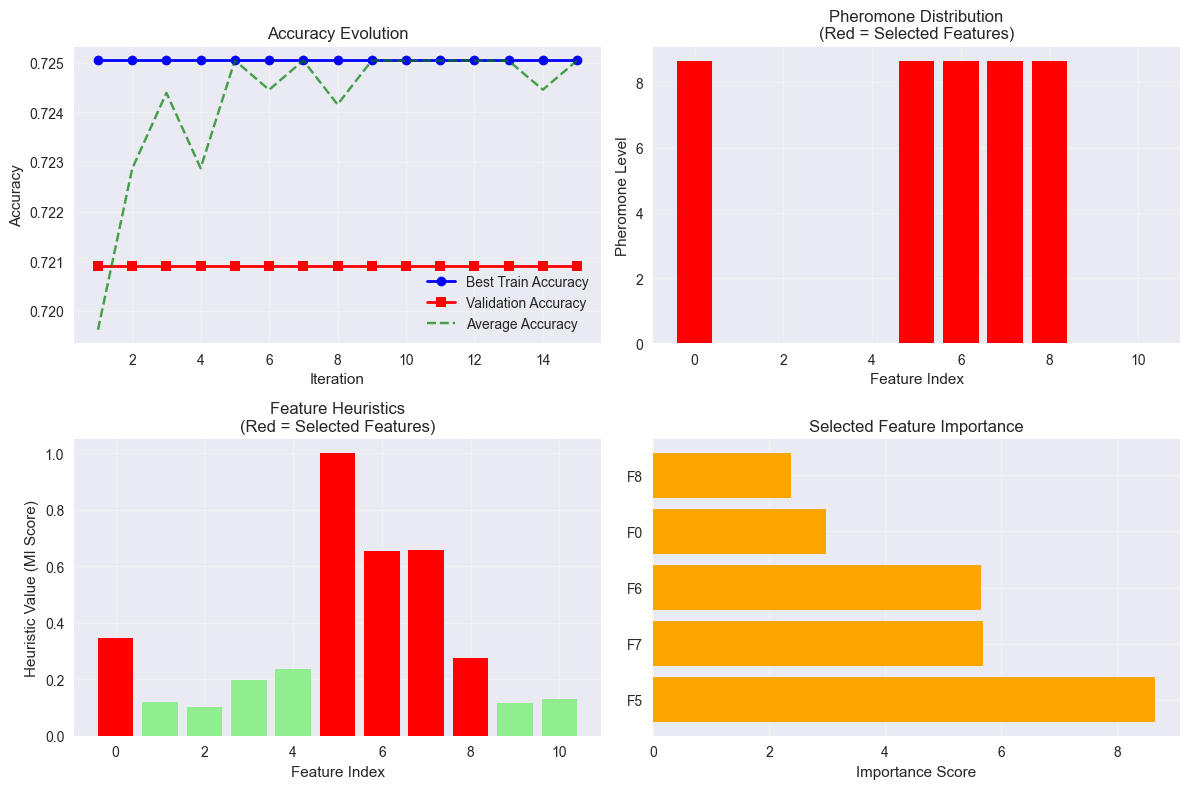

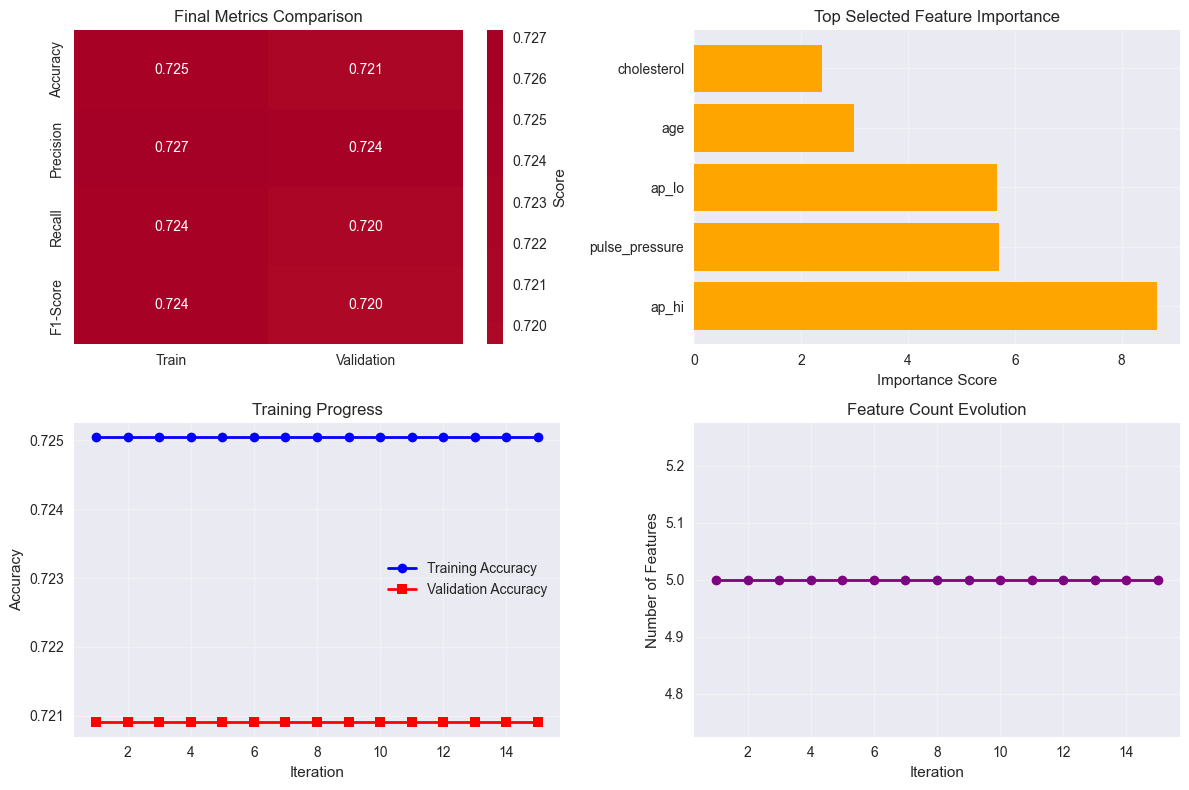

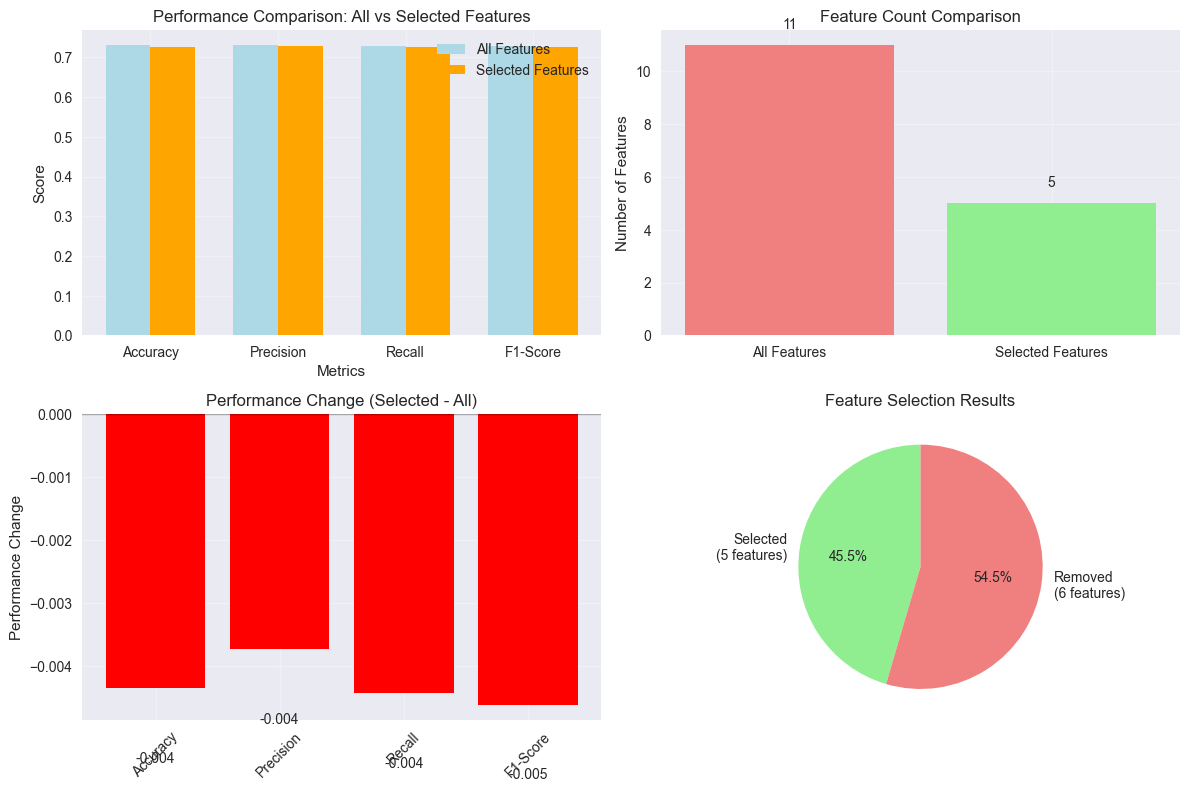


DETAILED PERFORMANCE SUMMARY
Metric          All Features    Selected        Change          % Change       
---------------------------------------------------------------------------
Accuracy        0.7303          0.7260          -0.0044         -0.60          %
Precision       0.7321          0.7284          -0.0037         -0.51          %
Recall          0.7297          0.7253          -0.0044         -0.61          %
F1              0.7294          0.7248          -0.0046         -0.63          %
---------------------------------------------------------------------------
Features        11              5               -6              -54.5          %

OVERALL ASSESSMENT:
⚠ Accuracy decreased: -0.0044
✓ Feature reduction achieved: 54.5%
🎯 SUCCESS: Significant feature reduction with minimal accuracy loss!


In [15]:
if __name__ == "__main__":
    aco, selected_indices, X_selected, results = run_lgbm_feature_selection(
        data_path="health_data_proccess.csv",
        target_column="group",
        n_ants=10,
        max_iter=15
    )

🚀 RUNNING ESSENTIAL COMPARISON
📊 Showing only 5 essential charts:
   1. Performance Metrics Comparison
   2. Training Time Comparison
   3. ROC Curves / AUC Comparison
   4. Confusion Matrices
   5. Memory Usage Comparison
--------------------------------------------------
🚀 STARTING DIRECT DATASET COMPARISON
📁 Raw Data: health_data_proccess.csv
🐜 ACO Data: health_data_ACO_ver2.csv
🎯 Target: group
🔧 Hyperparameter Tuning: Disabled
📊 Test Size: 30.0%
🚀 STARTING COMPLETE COMPARISON
Raw Data vs ACO-Processed Data
LOADING AND PREPARING DATASETS
📂 Loading raw data from: health_data_proccess.csv
   • Raw data shape: (62502, 12)
   • Features: 11
   • Samples: 62502

🐜 Loading ACO-processed data from: health_data_ACO_ver2.csv
   • ACO data shape: (62502, 6)
   • Features: 5
   • Samples: 62502
✅ Target values are consistent between datasets

📊 DATA SUMMARY:
   • Feature reduction: 11 → 5 (54.5% reduction)
   • Target classes: [0 1]
   • Class distribution:
     - Class 0: 31634 samples (50.6%

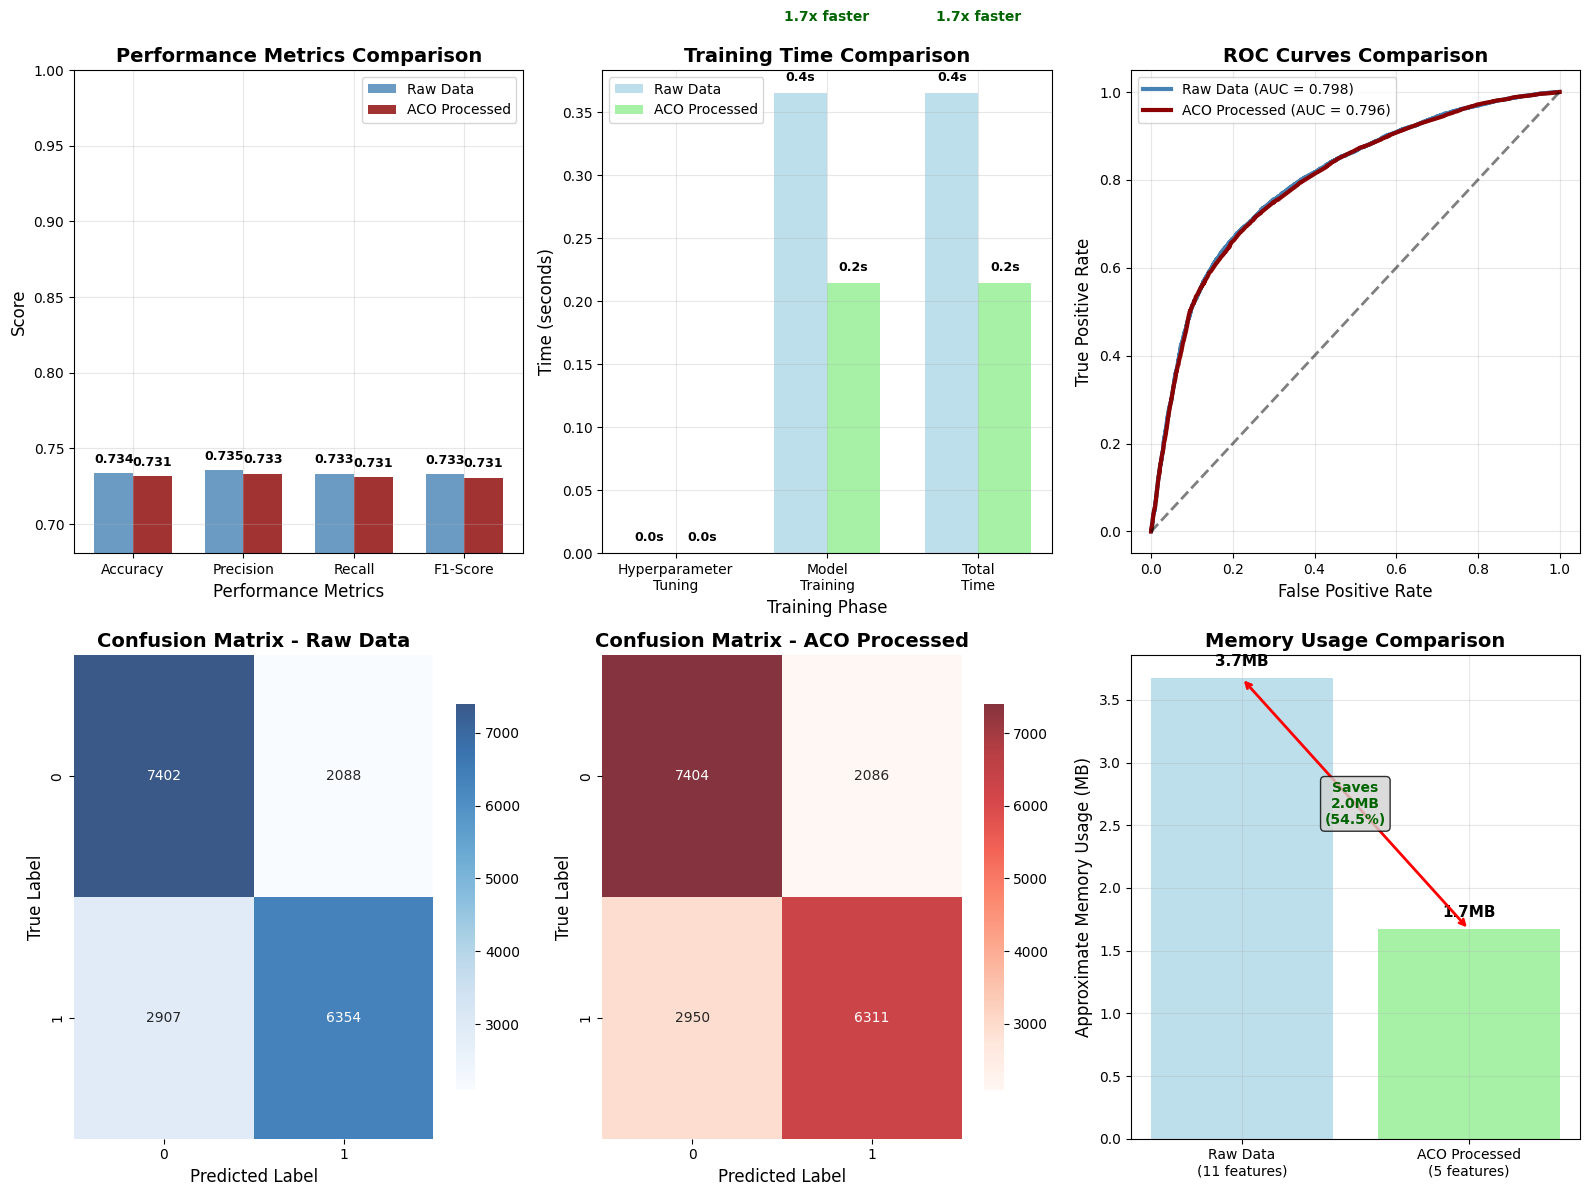


📊 ESSENTIAL VISUALIZATIONS SUMMARY
------------------------------------------------------------
✅ Performance Metrics: 4 key metrics compared
✅ Training Time: 0.4s vs 0.2s
✅ ROC/AUC: Binary classification curves
✅ Confusion Matrices: Prediction pattern comparison
✅ Memory Usage: 2.0MB (54.5%) saved

                           🔥 FORMATTED SUMMARY TABLE                            
❌ ERROR during comparison: 'DirectDataComparison' object has no attribute 'display_formatted_table'

🏁 ESSENTIAL COMPARISON COMPLETED!


In [ ]:
# Example usage
if __name__ == "__main__":
    
    essential_results = run_direct_comparison(
        raw_data_path="health_data_proccess.csv",
        aco_data_path="health_data_ACO_ver2.csv",
        target_column="group",
        hyperparameter_tuning=False,  # Faster for testing
        test_size=0.3,
        save_results=False
    )
    
    print("\n" + "="*80)
    print("🏁 ESSENTIAL COMPARISON COMPLETED!")
    print("="*80)

## ACO to OPTIMIZE PARAMETER LGBM

In [26]:
# Đọc file dữ liệu sau khi remove feature
df_1 = pd.read_csv('health_data_ACO_ver2.csv')

X_ACO_optimized = df_1.drop('group', axis=1)
y_ACO_optimized = df_1['group']  # Biến mục tiêu (0: Khỏe mạnh, 1: AMI)

# 2. Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_ACO_optimized, y_ACO_optimized, test_size=0.3, random_state=42, stratify=y_ACO_optimized)

# Không gian tham số để ACO tìm kiếm
param_space = {
    "num_leaves": [15, 31, 63, 127],
    "max_depth": [-1, 3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1],
    "min_child_samples": [10, 20, 40, 80],
    "feature_fraction": [0.6, 0.8, 1.0],
    "bagging_fraction": [0.6, 0.8, 1.0]
}

aco_hyper = ACOHyperparameterOptimizer(param_space, n_ants=10, max_iter=20, metric="auc")
best_params, best_score = aco_hyper.fit(X_ACO_optimized, y_ACO_optimized)

print("Best params:", best_params)
print("Best AUC:", best_score)

# Train mô hình cuối với tham số tối ưu
final_model = lgb.LGBMClassifier(**best_params, n_estimators=300, random_state=42)
final_model.fit(X_ACO_optimized, y_ACO_optimized)

Iteration 1/20 - Best AUC: 0.7929
Iteration 2/20 - Best AUC: 0.7929
Iteration 3/20 - Best AUC: 0.7929
Iteration 4/20 - Best AUC: 0.7929
Iteration 5/20 - Best AUC: 0.7929
Iteration 6/20 - Best AUC: 0.7929
Iteration 7/20 - Best AUC: 0.7929
Iteration 8/20 - Best AUC: 0.7929
Iteration 9/20 - Best AUC: 0.7929
Iteration 10/20 - Best AUC: 0.7929
Iteration 11/20 - Best AUC: 0.7929
Iteration 12/20 - Best AUC: 0.7929
Iteration 13/20 - Best AUC: 0.7929
Iteration 14/20 - Best AUC: 0.7929
Iteration 15/20 - Best AUC: 0.7929
Iteration 16/20 - Best AUC: 0.7929
Iteration 17/20 - Best AUC: 0.7929
Iteration 18/20 - Best AUC: 0.7929
Iteration 19/20 - Best AUC: 0.7929
Iteration 20/20 - Best AUC: 0.7929
Best params: {'num_leaves': 63, 'max_depth': 3, 'learning_rate': 0.05, 'min_child_samples': 10, 'feature_fraction': 1.0, 'bagging_fraction': 0.8}
Best AUC: 0.7929193579032462


LGBMClassifier(bagging_fraction=0.8, feature_fraction=1.0, learning_rate=0.05,
               max_depth=3, min_child_samples=10, n_estimators=300,
               num_leaves=63, random_state=42)

In [ ]:

# 5. Đánh giá mô hình
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# Độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác: {accuracy:.4f}")

# Báo cáo phân loại
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
print("\nMa trận nhầm lẫn:")
print(cm)

Độ chính xác: 0.7348

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      9490
           1       0.75      0.69      0.72      9261

    accuracy                           0.73     18751
   macro avg       0.74      0.73      0.73     18751
weighted avg       0.74      0.73      0.73     18751


Ma trận nhầm lẫn:
[[7346 2144]
 [2829 6432]]


In [28]:
X_ori = df_1.drop('group', axis=1)
y_ori = df_1['group']  # Biến mục tiêu (0: Khỏe mạnh, 1: AMI)

# 2. Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_ori, y_ori, test_size=0.3, random_state=42, stratify=y_ori)

# 3. Định nghĩa các tham số cho mô hình LGBM
params = {
    'n_estimators': 300,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'min_child_weight': 0.001,
    'min_child_samples': 20,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'random_state': 42
}

# 4. Huấn luyện mô hình LGBM
model = lgbm.LGBMClassifier(**params)
model.fit(X_train_final, y_train_final)

# 5. Đánh giá mô hình
y_pred = model.predict(X_test_final)
y_prob = model.predict_proba(X_test_final)[:, 1]

# Độ chính xác
accuracy = accuracy_score(y_test_final, y_pred)
print(f"Độ chính xác: {accuracy:.4f}")

# Báo cáo phân loại
print("\nBáo cáo phân loại:")
print(classification_report(y_test_final, y_pred))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test_final, y_pred)
print("\nMa trận nhầm lẫn:")
print(cm)

Độ chính xác: 0.7315

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      9490
           1       0.75      0.68      0.71      9261

    accuracy                           0.73     18751
   macro avg       0.73      0.73      0.73     18751
weighted avg       0.73      0.73      0.73     18751


Ma trận nhầm lẫn:
[[7410 2080]
 [2955 6306]]



=== CROSS-VALIDATION COMPARISON ===
LGBM Thông thường - CV AUC: 0.7887 (+/- 0.0062)
LGBM-ACO - CV AUC: 0.7917 (+/- 0.0067)


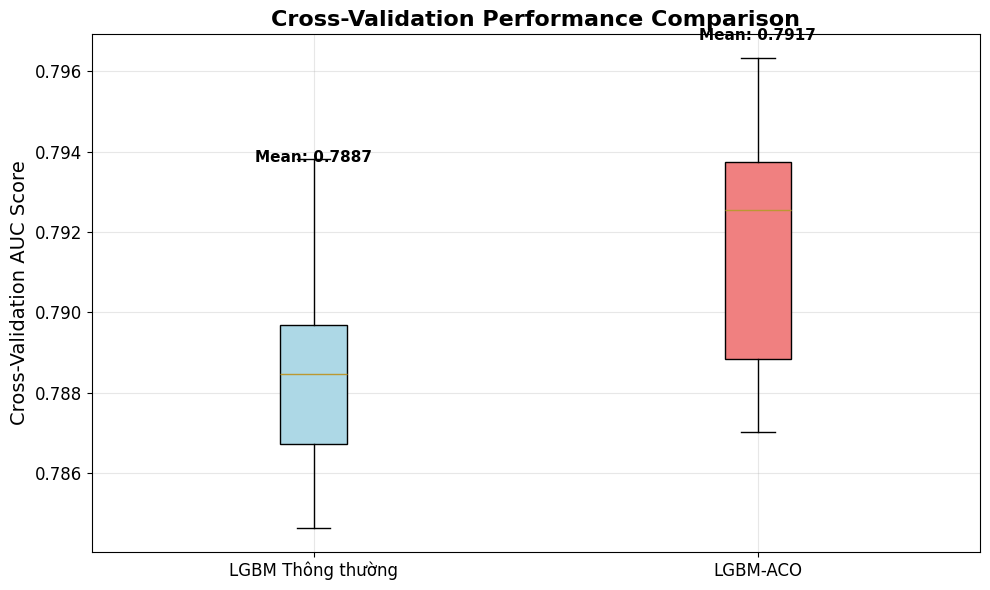

=== SO SÁNH CÁC CHỈ SỐ ===
      Chỉ số  LGBM Thông thường  LGBM-ACO
0   Accuracy             0.7315    0.7348
1  Precision             0.7520    0.7500
2     Recall             0.6809    0.6945
3   F1-Score             0.7147    0.7212
4        AUC             0.7946    0.8011

=== CẢI THIỆN ===
   Chỉ số  Cải thiện (%)
 Accuracy           0.45
Precision          -0.26
   Recall           2.00
 F1-Score           0.91
      AUC           0.81


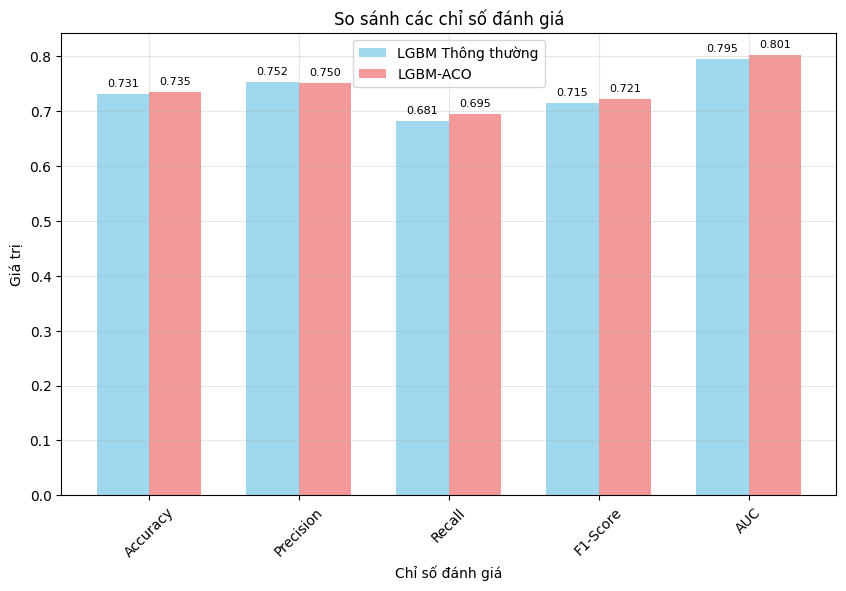

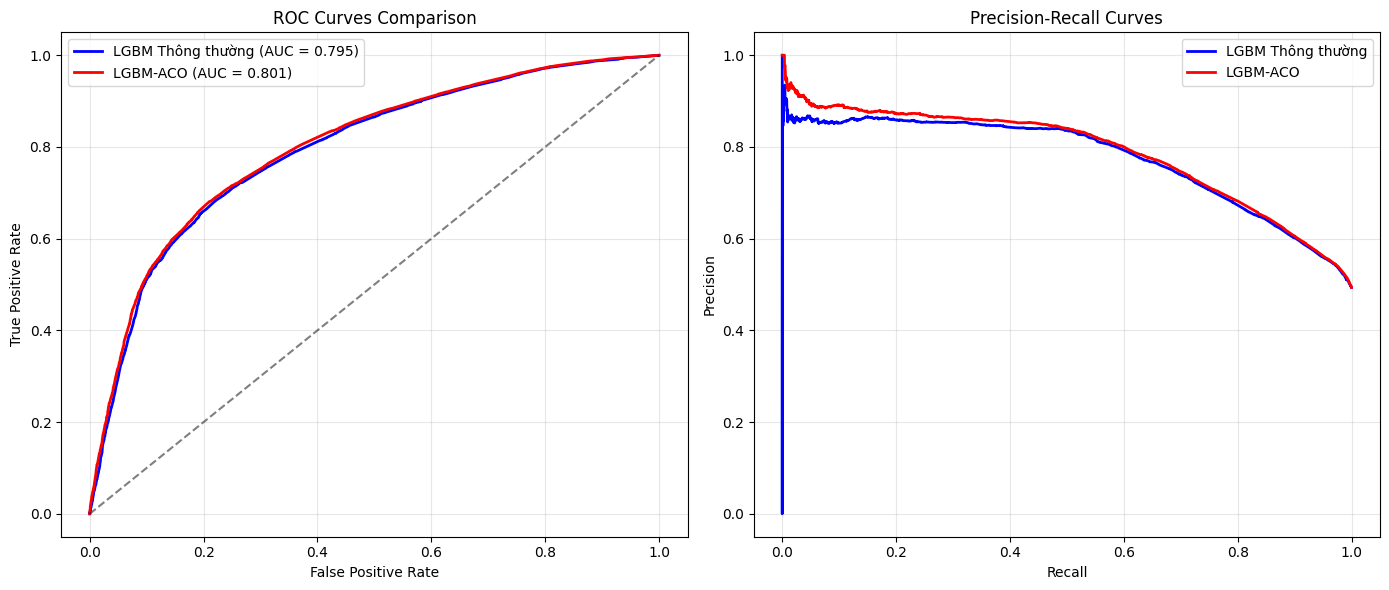

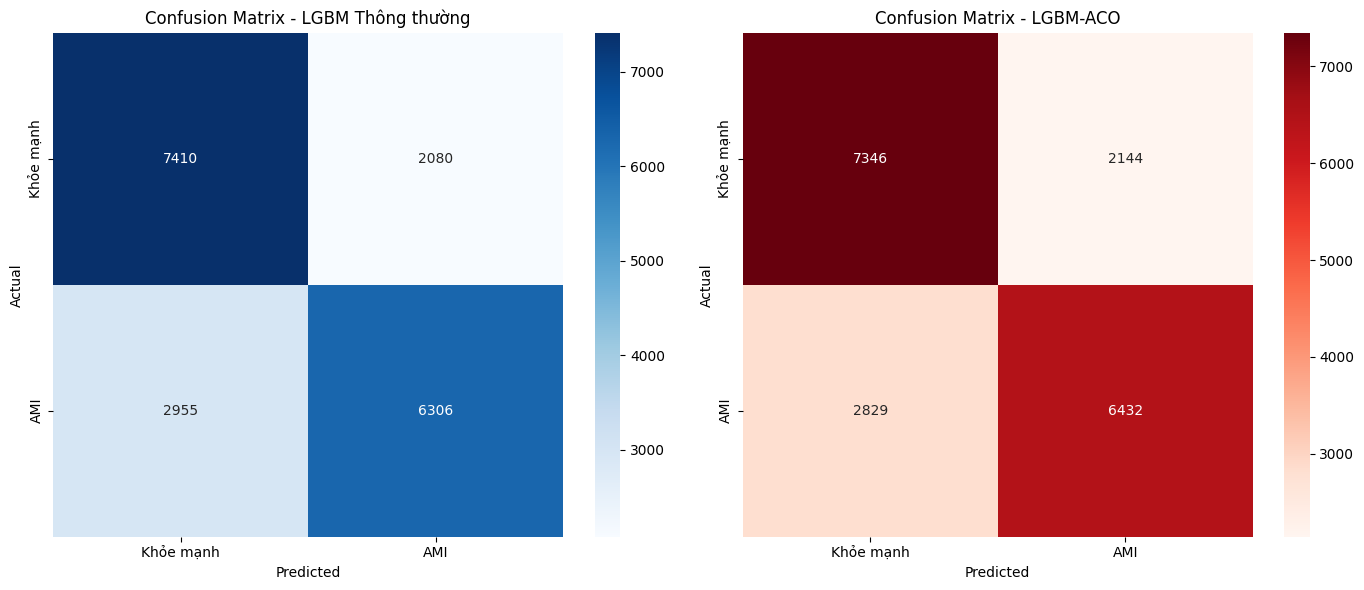


=== STATISTICAL SIGNIFICANCE TEST ===
T-statistic: -1.3305
P-value: 0.2200
Sự khác biệt không có ý nghĩa thống kê (p >= 0.05)

         TÓM TẮT KẾT QUẢ SO SÁNH
1. Độ chính xác:
   - LGBM Thông thường: 0.7315
   - LGBM-ACO: 0.7348
   - Cải thiện: +0.45%

2. AUC Score:
   - LGBM Thông thường: 0.7946
   - LGBM-ACO: 0.8011
   - Cải thiện: +0.81%

3. F1-Score:
   - LGBM Thông thường: 0.7147
   - LGBM-ACO: 0.7212
   - Cải thiện: +0.91%

4. Chỉ số cải thiện tốt nhất: Recall (+2.00%)

5. KẾT LUẬN: LGBM-ACO cho kết quả tốt hơn với AUC cao hơn 0.81%


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
import pandas as pd
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('default')
sns.set_palette("husl")

# ========================================
# 1. TÍNH TOÁN CÁC CHỈ SỐ CHO CẢ HAI MÔ HÌNH
# ========================================

# Dự đoán cho mô hình thông thường
y_pred_normal = model.predict(X_test_final)
y_prob_normal = model.predict_proba(X_test_final)[:, 1]

# Dự đoán cho mô hình ACO-optimized
y_pred_aco = final_model.predict(X_test)
y_prob_aco = final_model.predict_proba(X_test)[:, 1]

# Tính các chỉ số cho mô hình thông thường
accuracy_normal = accuracy_score(y_test_final, y_pred_normal)
precision_normal = precision_score(y_test_final, y_pred_normal)
recall_normal = recall_score(y_test_final, y_pred_normal)
f1_normal = f1_score(y_test_final, y_pred_normal)
auc_normal = roc_auc_score(y_test_final, y_prob_normal)

# Tính các chỉ số cho mô hình ACO
accuracy_aco = accuracy_score(y_test, y_pred_aco)
precision_aco = precision_score(y_test, y_pred_aco)
recall_aco = recall_score(y_test, y_pred_aco)
f1_aco = f1_score(y_test, y_pred_aco)
auc_aco = roc_auc_score(y_test, y_prob_aco)


# ========================================
# 4. CROSS-VALIDATION COMPARISON
# ========================================

print("\n=== CROSS-VALIDATION COMPARISON ===")
# Cross-validation cho mô hình thông thường
cv_scores_normal = cross_val_score(model, X_ori, y_ori, cv=5, scoring='roc_auc')
print(f"LGBM Thông thường - CV AUC: {cv_scores_normal.mean():.4f} (+/- {cv_scores_normal.std() * 2:.4f})")

# Cross-validation cho mô hình ACO
cv_scores_aco = cross_val_score(final_model, X_ACO_optimized, y_ACO_optimized, cv=5, scoring='roc_auc')
print(f"LGBM-ACO - CV AUC: {cv_scores_aco.mean():.4f} (+/- {cv_scores_aco.std() * 2:.4f})")

# Biểu đồ so sánh CV scores - Phóng to
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
box_data = [cv_scores_normal, cv_scores_aco]
box_labels = ['LGBM Thông thường', 'LGBM-ACO']

box_plot = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
box_plot['boxes'][1].set_facecolor('lightcoral')

ax.set_ylabel('Cross-Validation AUC Score', fontsize=14)
ax.set_title('Cross-Validation Performance Comparison', fontsize=16, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, alpha=0.3)

# Thêm giá trị trung bình lên boxplot
for i, scores in enumerate(box_data):
    ax.text(i+1, scores.mean() + 0.005, f'Mean: {scores.mean():.4f}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ========================================
# 2. TẠO DATAFRAME ĐỂ SO SÁNH
# ========================================

comparison_df = pd.DataFrame({
    'Chỉ số': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'LGBM Thông thường': [accuracy_normal, precision_normal, recall_normal, f1_normal, auc_normal],
    'LGBM-ACO': [accuracy_aco, precision_aco, recall_aco, f1_aco, auc_aco]
})

print("=== SO SÁNH CÁC CHỈ SỐ ===")
print(comparison_df.round(4))
print("\n=== CẢI THIỆN ===")
improvement_df = comparison_df.copy()
improvement_df['Cải thiện (%)'] = ((comparison_df['LGBM-ACO'] - comparison_df['LGBM Thông thường']) / comparison_df['LGBM Thông thường'] * 100).round(2)
print(improvement_df[['Chỉ số', 'Cải thiện (%)']].to_string(index=False))

# ========================================
# 3. VISUALIZATION
# ========================================

# 1. Biểu đồ cột so sánh các chỉ số
plt.figure(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = plt.bar(x - width/2, comparison_df['LGBM Thông thường'], width, 
                label='LGBM Thông thường', alpha=0.8, color='skyblue')
bars2 = plt.bar(x + width/2, comparison_df['LGBM-ACO'], width,
                label='LGBM-ACO', alpha=0.8, color='lightcoral')

plt.xlabel('Chỉ số đánh giá')
plt.ylabel('Giá trị')
plt.title('So sánh các chỉ số đánh giá')
plt.xticks(x, comparison_df['Chỉ số'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Thêm giá trị lên các cột
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.show()

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1 hàng, 2 cột

# ROC Curves
fpr_normal, tpr_normal, _ = roc_curve(y_test_final, y_prob_normal)
fpr_aco, tpr_aco, _ = roc_curve(y_test, y_prob_aco)

ax1.plot(fpr_normal, tpr_normal, label=f'LGBM Thông thường (AUC = {auc_normal:.3f})',
         linewidth=2, color='blue')
ax1.plot(fpr_aco, tpr_aco, label=f'LGBM-ACO (AUC = {auc_aco:.3f})',
         linewidth=2, color='red')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision–Recall Curves
precision_normal_curve, recall_normal_curve, _ = precision_recall_curve(y_test_final, y_prob_normal)
precision_aco_curve, recall_aco_curve, _ = precision_recall_curve(y_test, y_prob_aco)

ax2.plot(recall_normal_curve, precision_normal_curve, label='LGBM Thông thường',
         linewidth=2, color='blue')
ax2.plot(recall_aco_curve, precision_aco_curve, label='LGBM-ACO',
         linewidth=2, color='red')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))  # 1 hàng, 2 cột

# Confusion Matrix - Thông thường
cm_normal = confusion_matrix(y_test_final, y_pred_normal)
sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Khỏe mạnh', 'AMI'], yticklabels=['Khỏe mạnh', 'AMI'])
ax3.set_title('Confusion Matrix - LGBM Thông thường')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# Confusion Matrix - ACO
cm_aco = confusion_matrix(y_test, y_pred_aco)
sns.heatmap(cm_aco, annot=True, fmt='d', cmap='Reds', ax=ax4,
            xticklabels=['Khỏe mạnh', 'AMI'], yticklabels=['Khỏe mạnh', 'AMI'])
ax4.set_title('Confusion Matrix - LGBM-ACO')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ========================================
# 5. STATISTICAL SIGNIFICANCE TEST
# ========================================

from scipy import stats

print("\n=== STATISTICAL SIGNIFICANCE TEST ===")
# Kiểm tra sự khác biệt có ý nghĩa thống kê
t_stat, p_value = stats.ttest_ind(cv_scores_normal, cv_scores_aco)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Sự khác biệt có ý nghĩa thống kê (p < 0.05)")
else:
    print("Sự khác biệt không có ý nghĩa thống kê (p >= 0.05)")

# ========================================
# 6. SUMMARY REPORT
# ========================================

print("\n" + "="*50)
print("         TÓM TẮT KẾT QUẢ SO SÁNH")
print("="*50)

print(f"1. Độ chính xác:")
print(f"   - LGBM Thông thường: {accuracy_normal:.4f}")
print(f"   - LGBM-ACO: {accuracy_aco:.4f}")
print(f"   - Cải thiện: {((accuracy_aco - accuracy_normal) / accuracy_normal * 100):+.2f}%")

print(f"\n2. AUC Score:")
print(f"   - LGBM Thông thường: {auc_normal:.4f}")
print(f"   - LGBM-ACO: {auc_aco:.4f}")
print(f"   - Cải thiện: {((auc_aco - auc_normal) / auc_normal * 100):+.2f}%")

print(f"\n3. F1-Score:")
print(f"   - LGBM Thông thường: {f1_normal:.4f}")
print(f"   - LGBM-ACO: {f1_aco:.4f}")
print(f"   - Cải thiện: {((f1_aco - f1_normal) / f1_normal * 100):+.2f}%")

# Tìm chỉ số cải thiện tốt nhất
best_improvement_idx = improvement_df['Cải thiện (%)'].abs().idxmax()
best_metric = improvement_df.loc[best_improvement_idx, 'Chỉ số']
best_improvement = improvement_df.loc[best_improvement_idx, 'Cải thiện (%)']

print(f"\n4. Chỉ số cải thiện tốt nhất: {best_metric} ({best_improvement:+.2f}%)")

if auc_aco > auc_normal:
    print(f"\n5. KẾT LUẬN: LGBM-ACO cho kết quả tốt hơn với AUC cao hơn {((auc_aco - auc_normal) / auc_normal * 100):.2f}%")
else:
    print(f"\n5. KẾT LUẬN: LGBM thông thường cho kết quả tốt hơn")

print("="*50)